In [1]:
import gym
import math
import random
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
env = gym.make('CartPole-v0', render_mode='rgb_array').unwrapped
plt.ion()
device = torch.device("mps")

is_ipython = "inline" in matplotlib.get_backend()

/Users/saaketh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [3]:
# Transition class: named tuple representing a single transition in the environment.
# maps (s,a) pairs to (s', r) result. State here is screen image.
# ReplayMemory: buffer of bounded size that holds recently observed transitions
# should implement a .sample() method for selecting a random batch of transitions for training.

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        # saves a transition in replay memory
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
# environment here is determininstic.
# in literature, would contain expectations over transitions in environment. (non-deterministic)
# maximize discounted cumulative reward (discount param gamma)
# want neural net to be our Q function on (s,a). Input s, output Q(s,a) for all actions possible
# policy pi defined by this neural net is pi(s) = argmax(a) Q(s,a)
# update through temporal difference learning:
# Q_pi(s,a) = r + gamma*(Q_pi(s', pi(s'))) = B
# sum of expected reward from (s,a) --> r and the Q value of subsequent state s' and pi(s').
# There should be an expectation here...expectation over all end states s', and transition probabilities.
# temporal difference error: delta = Q(s,a) - (r + gamma*(max Q(s', a)))
# Huber loss: MSE when error small, MAE when error large --> robust to outliers whenw e have noisy estimates of Q

# model is a CNN that takes in the difference between the current and previous screen patches
# two outputs: one for Q(s, left) and one for Q(s, right)

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            # want to make sure the layer sizes change even with different input image sizes
            return (size - (kernel_size-1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

        linear_input_size = convw*convh*32
        self.head = nn.Linear(linear_input_size, outputs)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


In [6]:
# these functions are mostly irrelevant for what we are doing in adaptive sampling. just copypasted lol.

resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold*2
    scale = screen_width/world_width
    return int(env.state[0]*scale + screen_width/2.0)

def get_screen():
    # transpose into CHW order
    screen = env.render().transpose((2,0,1))
    # cart is in lower half so take off the top and bottom of screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

/var/folders/w9/7_3vhgzs0nz2lqjstb18tyyr0000gn/T/ipykernel_41186/4122255434.py:3: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])
/Users/saaketh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


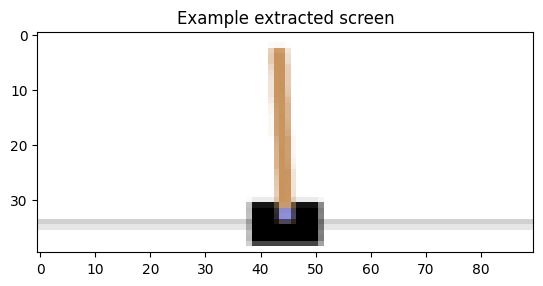

In [7]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [8]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9 # high exploration initially
EPS_END = 0.05 # low exploration at end
EPS_DECAY = 200 # controls epsilon decay rate
TARGET_UPDATE = 10

In [9]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

# select_action function selects action according to epsilon greedy policy
# parameter epsilon is the probability of exploring instead of exploiting.
# plot_durations function is a helper for plotting durations of episodes
# along with an average over last 100 episodes.
steps_done = 0

def select_action(state):
    global steps_done
    # sample from 0-1 uniform
    sample = random.random()
    # exponential decay of epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # not within epsilon, so we exploit
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # within epsilon, explore. here we are returning random actions.
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(wipe=True):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.3)  # pause a bit so that plots are updated
    if is_ipython and wipe:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [10]:
# optimize_model function performs sincle step of optimization.
# samples batch, concatenates tensors, computes Q(s_t, a_t) and V(s_t+1) = max Q(s_t+1, a)
# combines these into our loss. V(s) = 0 if terminal state.
# target network computes V(s_t+1) for stability. Target network parameters frozen and are updated
# with policy network's weights at regular intervals.

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch=Transition(*zip(*transitions))

    print("LENGTH OF MEMORY BUFFER:", len(memory))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) -- model computes Q(s_t), then we select
    # the columns of actions taken. These are actions which would have
    # been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_t+1) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # compute expected q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute Huber Loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        # in place version of clamp
        # lol why are we doing this...
        param.grad.data.clamp_(-1,1)
    optimizer.step()

In [11]:
# training loop
num_episodes = 300
for i_episode in range(num_episodes):
    # initialize environment and state
    if i_episode % 5 == 0:
        print("Episode", i_episode)
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # select and perform action
        action = select_action(state)
        # so they are receiving some type of reward from environment here.
        # need to decide how this function will operate
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            # terminal state reached
            next_state = None
        
        # store transition in memory
        memory.push(state, action, next_state, reward)

        # move to next state
        state = next_state

        # perform one step of optimization (only on policy network rn)
        optimize_model()
        if done:
            episode_durations.append(t+1)
            #plot_durations()
            break

        # update target network by copying from policy net
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print("Complete")
env.render()
env.close()
plt.ioff()
plt.show()

Episode 0
Episode 5
LENGTH OF MEMORY BUFFER: 128


/var/folders/w9/7_3vhgzs0nz2lqjstb18tyyr0000gn/T/ipykernel_41186/1466696414.py:35: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()


LENGTH OF MEMORY BUFFER: 129
LENGTH OF MEMORY BUFFER: 130
LENGTH OF MEMORY BUFFER: 131
LENGTH OF MEMORY BUFFER: 132
LENGTH OF MEMORY BUFFER: 133
LENGTH OF MEMORY BUFFER: 134
LENGTH OF MEMORY BUFFER: 135
LENGTH OF MEMORY BUFFER: 136
LENGTH OF MEMORY BUFFER: 137
LENGTH OF MEMORY BUFFER: 138
LENGTH OF MEMORY BUFFER: 139
LENGTH OF MEMORY BUFFER: 140
LENGTH OF MEMORY BUFFER: 141
LENGTH OF MEMORY BUFFER: 142
LENGTH OF MEMORY BUFFER: 143
LENGTH OF MEMORY BUFFER: 144
LENGTH OF MEMORY BUFFER: 145
LENGTH OF MEMORY BUFFER: 146
LENGTH OF MEMORY BUFFER: 147
LENGTH OF MEMORY BUFFER: 148
LENGTH OF MEMORY BUFFER: 149
LENGTH OF MEMORY BUFFER: 150
LENGTH OF MEMORY BUFFER: 151
LENGTH OF MEMORY BUFFER: 152
LENGTH OF MEMORY BUFFER: 153
LENGTH OF MEMORY BUFFER: 154
LENGTH OF MEMORY BUFFER: 155
LENGTH OF MEMORY BUFFER: 156
LENGTH OF MEMORY BUFFER: 157
LENGTH OF MEMORY BUFFER: 158
LENGTH OF MEMORY BUFFER: 159
LENGTH OF MEMORY BUFFER: 160
LENGTH OF MEMORY BUFFER: 161
LENGTH OF MEMORY BUFFER: 162
LENGTH OF MEMO

KeyboardInterrupt: 

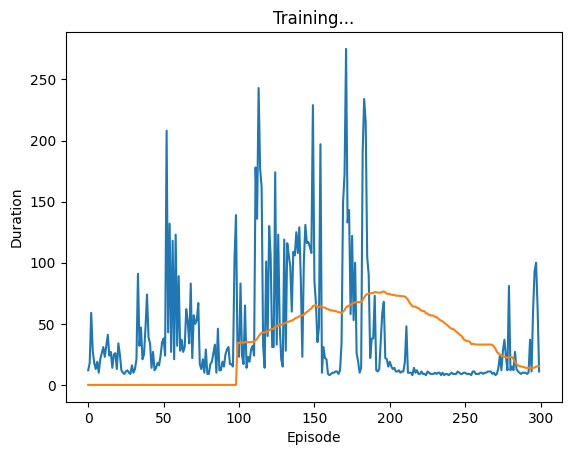

In [74]:
plot_durations(wipe=False)